# Problem

Explain total funding attracted by one or more variables provided in data

# Solution

In [1]:
import re
import time
import random
import numpy as np
import pandas as pd
import scipy

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,  StratifiedKFold, RepeatedStratifiedKFold

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# NLP
import eli5
from string import punctuation
from nltk.corpus import stopwords
from pymystem3.mystem import Mystem

In [2]:
data = pd.read_csv("Data_1000.csv")

In [3]:
data

,Organization Name,Organization Name URL,Headquarters Location,Headquarters Regions,Diversity Spotlight (US Headquarters Only),Estimated Revenue Range,Description,Operating Status,Founded Date,Founded Date Precision,...,SEMrush - Page Views / Visit Growth,SEMrush - Bounce Rate,SEMrush - Bounce Rate Growth,SEMrush - Global Traffic Rank,SEMrush - Monthly Rank Change (#),SEMrush - Monthly Rank Growth,BuiltWith - Active Tech Count,Apptopia - Number of Apps,Apptopia - Downloads Last 30 Days,G2 Stack - Total Products Active
0,MADE,https://www.crunchbase.com/organization/made,"London, England, United Kingdom",NaN,NaN,NaN,Made.com is an online e-commerce platform dire...,Active,2010-01-01,year,...,-33.55%,84.05%,33.77%,"157,034","117,128",293.51%,33.0,NaN,NaN,43.0
1,Gymshark,https://www.crunchbase.com/organization/gymshark,"Solihull, Solihull, United Kingdom",NaN,NaN,$10M to $50M,Gymshark is an online retailer and technology ...,Active,2012-01-01,year,...,-34.93%,45.41%,34.51%,"12,807","4,809",60.13%,107.0,NaN,NaN,43.0
2,THG,https://www.crunchbase.com/organization/the-hu...,"Manchester, Manchester, United Kingdom",NaN,NaN,$1B to $10B,THG is an online retailing platform focused on...,Active,2004-01-01,year,...,15.8%,71.37%,-3.74%,"572,245","265,933",86.82%,9.0,2.0,"2,408",19.0
3,Trouva,https://www.crunchbase.com/organization/wearet...,"London, England, United Kingdom",NaN,NaN,$10M to $50M,"Trouva, the leading platform to discover and s...",Active,2015-09-01,month,...,0.37%,73.15%,-6.66%,"158,302","21,845",16.01%,81.0,2.0,"1,725",29.0
4,Upstream,https://www.crunchbase.com/organization/upstre...,"London, England, United Kingdom",NaN,NaN,NaN,Upstream is a mobile marketing technology comp...,Active,2001-01-01,year,...,136.24%,37.05%,-57.08%,"6,682,937","1,855,470",38.44%,56.0,7.0,NaN,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BetterCommerce,https://www.crunchbase.com/organization/better...,"Harrow On The Hill, Harrow, United Kingdom",NaN,NaN,$10M to $50M,BetterCommerce is a headless and composable co...,Active,2015-11-03,day,...,0.24%,0%,NaN,"8,126,129","556,625",7.35%,33.0,NaN,NaN,18.0
996,grüum,https://www.crunchbase.com/organization/grüum,"Manchester, Manchester, United Kingdom",NaN,NaN,$1M to $10M,grüum is an e-commerce retailer of beauty and ...,Active,2016-01-01,year,...,68.95%,35.13%,-37.78%,"201,536","27,639",15.89%,90.0,NaN,NaN,NaN
997,Go Instore,https://www.crunchbase.com/organization/go-ins...,"London, England, United Kingdom",NaN,NaN,$1M to $10M,Go Instore is a unique technology that closes ...,Active,2014-01-01,year,...,6.6%,85.66%,-7.71%,"7,403,665","5,441,122",277.25%,46.0,1.0,NaN,11.0
998,The White Company,https://www.crunchbase.com/organization/the-wh...,"London, England, United Kingdom",NaN,NaN,NaN,"We’ve been making impeccably stylish, beautifu...",Active,1994-01-01,year,...,-21.17%,39.62%,-12.17%,"42,458","-2,292",-5.12%,44.0,NaN,NaN,41.0


# EDA

In [4]:
print(f"Duplicates in dataset: {data.duplicated().sum()}")

Duplicates in dataset: 0


It seems, like "Total Funding Amount" feature is the one that we need to analize, however we will actually use only "Total Funding Amount Currency (in USD)" because it is easier to deal with.

For simplicity let's rename "Total Funding Amount Currency (in USD)" to target

In [5]:
data.rename(columns = {"Total Funding Amount Currency (in USD)":"Target"},
            inplace = True)

In [6]:
data["Target"]

0      1.368587e+08
1      2.453001e+08
2      5.043153e+09
3      4.105982e+07
4      7.053692e+07
           ...     
995             NaN
996             NaN
997             NaN
998             NaN
999             NaN
Name: Target, Length: 1000, dtype: float64

In [7]:
data["Target"].isnull().sum()

187

Unfortunaly, we have missing data in target column, therefore, we must drop those rows

In [8]:
data.dropna(axis=0,
            subset=["Target"],
            inplace=True)
data = data.reset_index(drop=True)

Let's explore the target closer:

(0.0, 50.0)

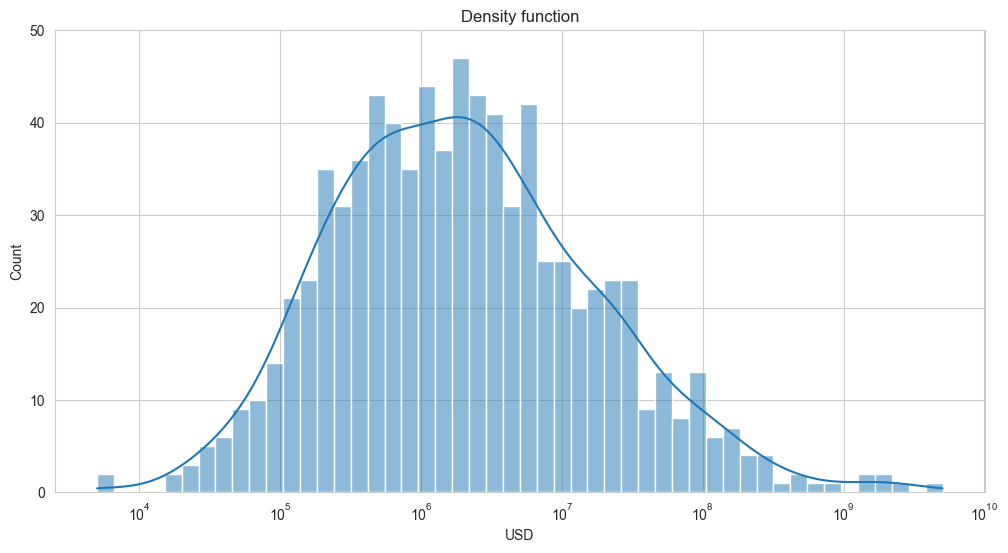

In [9]:
fig = plt.gcf()
fig.set_size_inches(12, 6)
sns.set_style("whitegrid")
ax = sns.histplot(np.array(data["Target"].dropna()),
                  kde=True,
                  bins=50,
                  log_scale=True)
ax.set(xlabel="USD", title="Density function")
ax.set_ylim([0, 50])

In [10]:
data["Target"].median()

1809716.0

In [11]:
print("First quartile")
print(np.percentile(data["Target"], 25))

print("Third quartile")
print(np.percentile(data["Target"], 75))

First quartile
439369.0
Third quartile
7537177.0


In [12]:
# Coefficient of variation
print(scipy.stats.variation(data["Target"]))

7.119935550199631


# Missing values

Our target has missing values, therefore, we definitely should explore other columns

In [13]:
missing_data = {}

for col in data.columns:
    missing = data[col].isnull().sum() / len(data)
    missing_data[col] = missing
    if missing:
        print(col, np.round(missing * 100), "%")

Headquarters Regions 100.0 %
Diversity Spotlight (US Headquarters Only) 100.0 %
Estimated Revenue Range 49.0 %
Founded Date 0.0 %
Founded Date Precision 0.0 %
Exit Date 88.0 %
Exit Date Precision 88.0 %
Closed Date 98.0 %
Closed Date Precision 90.0 %
Company Type 5.0 %
Website 0.0 %
Twitter 22.0 %
Facebook 20.0 %
LinkedIn 17.0 %
Contact Email 16.0 %
Phone Number 47.0 %
Number of Articles 34.0 %
Hub Tags 99.0 %
Full Description 7.0 %
Actively Hiring 98.0 %
Investor Type 100.0 %
Investment Stage 100.0 %
Number of Portfolio Organizations 99.0 %
Number of Investments 99.0 %
Number of Lead Investments 99.0 %
Number of Diversity Investments 100.0 %
Number of Exits 99.0 %
Number of Exits (IPO) 99.0 %
Accelerator Program Type 100.0 %
Accelerator Application Deadline 100.0 %
Accelerator Duration (in weeks) 100.0 %
School Type 100.0 %
School Program 100.0 %
Number of Enrollments 100.0 %
School Method 100.0 %
Number of Founders (Alumni) 100.0 %
Number of Alumni 100.0 %
Number of Founders 4.0 %
Fo

Apparently, we have got to many features to analize them all.

We do not need features with different currencies but the same information. So, we leave only info in USD.

In [14]:
to_drop = ['Last Funding Amount',
            'Last Funding Amount Currency',
            'Last Equity Funding Amount',
            'Last Equity Funding Amount Currency',
            'Total Funding Amount',
            'Total Funding Amount Currency',
            'Total Equity Funding Amount',
            'Total Equity Funding Amount Currency',
            'Valuation at IPO',
            'Valuation at IPO Currency',
            'Money Raised at IPO',
            'Money Raised at IPO Currency',
            'Price',
            'Price Currency']

Obviously, there not much information in the urls themselves (they could be used for scrapping so we could get more data, however, it would take some time, so now we will just drop them)

Also, phone number and email information would not help us (too much unique values)

In [15]:
to_drop += ['Website',
            'Twitter',
            'Facebook',
            'LinkedIn',
            'Contact Email',
            'Phone Number',
            'Organization Name URL',
            'Stock Symbol URL',
            'Acquired by URL',
            'Transaction Name URL']

Let's fill missing data "Full Description" using "Description"

In [16]:
data["Full Description"] = data.apply(
    lambda row: row["Description"]
    if pd.isnull(row["Full Description"])
    else row["Full Description"],
    axis=1
)

Now we can drop "Description"

In [17]:
to_drop += ["Description"]

"Founders" feature is an interesting one: maybe, it is possible to predict target value based on founders names. However, it would be reather diffucult, because we have to much unique values and it would unbelievably increase the complexity of model. Therefore, we just drop the column.

In [18]:
to_drop += ["Founders"]

"Top 5 Investors" is an interesting feature, however, for simplicity of model we will drop it as we did with funders

In [19]:
to_drop += ["Top 5 Investors"]

It would be impossible in this case to fill missing values if they all are missing

In [20]:
to_drop += [key for key, value in missing_data.items() if value == 1]

"Operating Status Active" has only missing values, we will drop it

## Dates

As for the dates, we will convert them into unix format.  "Closed Date" has to many missing values. Same goes for "Delisted Date". 

If there is now information about "Exit Date", it means that company hasn't exited yet, so we fill it with todays date. As for "Founded Date", it has one or two missing values that we will fill with 0 (as well as those values that are out of bounds). We will create "Duration" column as "Founded Date" - "Exit Date". 

In [21]:
data["Founded Date"]

0      2010-01-01
1      2012-01-01
2      2004-01-01
3      2015-09-01
4      2001-01-01
          ...    
808    2014-02-01
809    1600-12-31
810    2012-08-18
811    2014-10-30
812    2012-06-01
Name: Founded Date, Length: 813, dtype: object

In [22]:
data["Founded Date"] = pd.to_datetime(data["Founded Date"],
                            infer_datetime_format=True,
                            errors="coerce").fillna(0)
data["Exit Date"].fillna(pd.Timestamp.today(), inplace=True)

In [23]:
data["Founded Date"] = data["Founded Date"].apply(
    lambda x: pd.to_datetime(x, errors='coerce').value
    )

data["Exit Date"] = data["Exit Date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce").value
    )

In [24]:
data["FoundedExitDuration"] = data["Exit Date"] - data["Founded Date"]

That means that now we may drop 'Exit Date', 'Founded Date' and their precision. Also, we can drop 'Closed Date' as we stated earlier

In [25]:
to_drop += ['Exit Date',
            'Founded Date',
            'Founded Date Precision',
            'Exit Date Precision',
            'Closed Date',
            'Closed Date Precision',
]

In [26]:
data.drop(to_drop, axis=1, inplace=True)

for col in to_drop:
    if col in missing_data.keys():
        missing_data.pop(col)

Like before we can convert 'Last Funding Date' to unix

In [27]:
data["Last Funding Date"].fillna(pd.Timestamp.today(), inplace=True)

data["Last Funding Date"] = data["Last Funding Date"].apply(
    lambda x: pd.to_datetime(x, errors="coerce").value
    )

## Estimated Revenue Range

Let's convert "Estimated Revenue Range" to appropriate format. Just for now we fill missing values with -1

In [28]:
def text_to_num(text):
    d = {
        "K": 1000,
        "M": 1000000,
        "B": 1000000000
    }

    if text[-1] in d:
        num, magnitude = text[:-1], text[-1]
        return int(float(num) * d[magnitude])
    else:
        return float(text)

In [29]:
def convert_revenue(text):
    if not isinstance(text, str):
        return -1
    
    revenue_range = text.split("$")
    
    # Last number
    if revenue_range[0] == "Less than ":
        return text_to_num(revenue_range[-1])
    
    # Difference of revenue range
    return(text_to_num(revenue_range[-1]) - text_to_num(revenue_range[1].split(" ")[0]))

In [30]:
data["Estimated Revenue Range"] = data["Estimated Revenue Range"].apply(lambda row: convert_revenue(row))

Then we explore correlation between "Estimated Revenue Range" and other features to fill these values correctly

<AxesSubplot: >

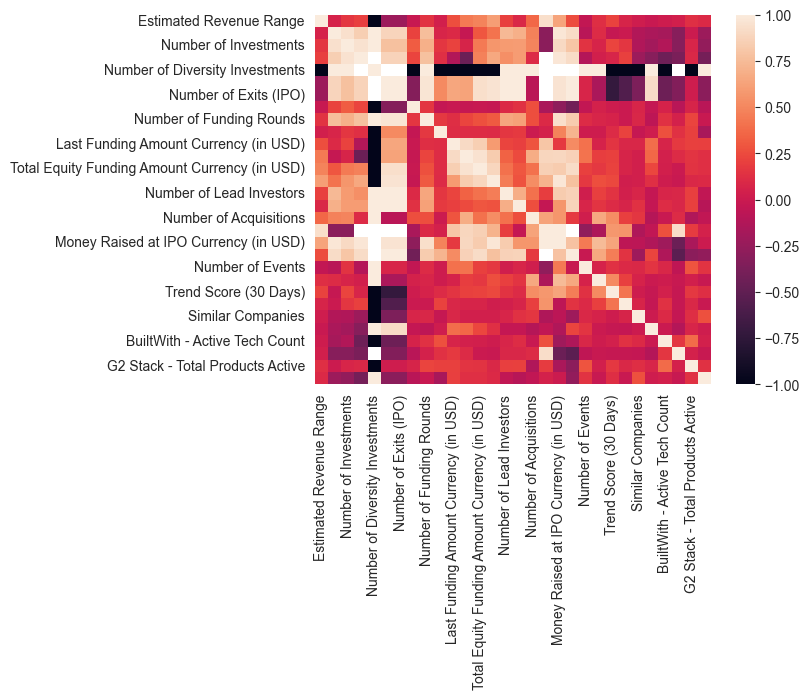

In [31]:
sns.heatmap(data.corr(numeric_only=True))

It is highly correlated with 'Total Equity Funding Amount Currency (in USD)'

However, 'Total Equity Funding Amount Currency (in USD)' has missing values. We fill them with the median value

In [32]:
data["Total Equity Funding Amount Currency (in USD)"].fillna(
    data["Total Equity Funding Amount Currency (in USD)"].median(),
    inplace=True
)

In [33]:
def fill_revenue(row):
    if row["Estimated Revenue Range"] == -1:
        row["Estimated Revenue Range"] = row["Total Equity Funding Amount Currency (in USD)"] * corr
    return row

In [34]:
corr = data["Estimated Revenue Range"].corr(
    data["Total Equity Funding Amount Currency (in USD)"]
)
data = data.apply(fill_revenue, axis=1)

## Number of Articles

Let's convert "Number of Articles" from string to int and fill missing values with 0

In [35]:
data["Number of Articles"].fillna(0, inplace=True)
data["Number of Articles"] = data["Number of Articles"].apply(lambda row: int(row))

It actually has linear correlation with target

In [36]:
scipy.stats.pearsonr(data["Target"], data["Number of Articles"])

PearsonRResult(statistic=0.42115426832617553, pvalue=2.7268248413881767e-36)

## Operating Status

We can see that it is a binary column

In [37]:
data["Operating Status"].unique()

array(['Active', 'Closed'], dtype=object)

In [38]:
mapping = {"Active": 1, "Closed": 0}
data["Operating Status Active"] = data["Operating Status"].map(mapping)
data.drop(["Operating Status"], axis=1, inplace=True)

## Company Type

Same goes for "Company Type" but we also fill missing values with mode

In [39]:
data["Company Type"].fillna(data["Company Type"].mode(), inplace=True)

In [40]:
data["Company Type"].unique()

array(['For Profit', nan, 'Non-profit'], dtype=object)

In [41]:
mapping = {"For Profit": 1, "Non-profit": 0}
data["For Profit"] = data["Company Type"].map(mapping)
data.drop(["Company Type"], axis=1, inplace=True)

## Actively Hiring

In [42]:
data["Actively Hiring"].unique()

array([nan, 'Yes'], dtype=object)

In [43]:
data["Actively Hiring"].fillna("No", inplace=True)
data["Actively Hiring"] = data["Actively Hiring"].map({"Yes":1,"No":0})

It would be a challenging task to fill missing data in column where most of it missing. Also, these features are not extremely important

In [44]:
to_drop = [key for key, value in missing_data.items() if value > 0.5]

In [45]:
data.drop(to_drop, axis=1, inplace=True)

for col in to_drop:
    if col in missing_data.keys():
        missing_data.pop(col)

## Number of Founders

In [46]:
missing_data["Number of Founders"]

0.041820418204182044

In [47]:
data["Number of Founders"].fillna(np.round(data["Number of Founders"].median()), inplace=True)

## Number of Employees

In [48]:
missing_data["Number of Employees"]

0.012300123001230012

In [49]:
data["Number of Employees"].fillna(data["Number of Employees"].mode().iloc[0], inplace=True)

In [50]:
def convert_n_employees(text):
    if text[-1] == "+":
        return int(text[:-1])
    return int(text.split("-")[1]) - int(text.split("-")[0])

In [51]:
data["Number of Employees"] = data["Number of Employees"].apply(lambda row: convert_n_employees(row))

## Funding Status

In [52]:
missing_data["Funding Status"]

0.3075030750307503

In [53]:
data["Funding Status"].unique()

array(['M&A', 'Private Equity', 'IPO', nan, 'Early Stage Venture', 'Seed',
       'Late Stage Venture'], dtype=object)

In [54]:
def check_categorical_correlation(categorical1,
                                  categorical2,
                                  p=0.05):
    contingency_table = pd.crosstab(categorical1,
                                    categorical2,
                                    dropna=True)
    chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)
    if (p_value < p):
        return True
    return False

In [55]:
check_categorical_correlation(data["Funding Status"], data["Number of Employees"])

True

In [56]:
data["Funding Status"] = data.apply(
    lambda row: row["Funding Status"] if isinstance(row["Funding Status"], str)
    else data[row["Number of Employees"] == data["Number of Employees"]]["Funding Status"].mode(),
    axis=1
)

We fill 'Number of Lead Investors' and 'Number of Investors' with zero, assuming, that if there is no information about investors than there are no investors.

In [57]:
data["Number of Lead Investors"].fillna(0, inplace=True)
data["Number of Investors"].fillna(0, inplace=True)

## Last Funding Amount Currency (in USD)

In [58]:
def check_categorical_numerical_correlation(data, categorical,
                                            numerical, p=0.05):
    statistic, p_value = scipy.stats.shapiro(data[numerical])
    # Shapiro-Wilk test
    shapiro_p_value = scipy.stats.shapiro(data[numerical])[1]
    groups = [group[1][numerical] for group in data.groupby(categorical)]
    if shapiro_p_value > p:
        # Normally distributed
        # ANOVA Test
        f_value, p_value = scipy.stats.f_oneway(*groups)
    else:
        # Not normally distributed
        # Kruskal-Wallis Test
        h_value, p_value = scipy.stats.kruskal(*groups)
    if p_value < p:
        return True
    return False

In [59]:
check_categorical_numerical_correlation(data, "Last Funding Type",
                                        "Last Funding Amount Currency (in USD)")

False

No correlation with type, maybe we will get luck with some numerical column

In [60]:
corr = scipy.stats.pearsonr(data["Total Equity Funding Amount Currency (in USD)"],
                     data["Last Funding Amount Currency (in USD)"].fillna(0))
print(corr)

PearsonRResult(statistic=0.8153852523449304, pvalue=1.0436027753632617e-194)


They are correlated. Let's fill missing values

In [61]:
def fill_last_funding_amount(row):
    if np.isnan(row["Last Funding Amount Currency (in USD)"]):
        row["Last Funding Amount Currency (in USD)"] = row["Total Equity Funding Amount Currency (in USD)"] * corr[0]
    return row

In [62]:
data = data.apply(fill_last_funding_amount,
                  axis=1)

## Last Equity Funding Type

In [63]:
data["Last Equity Funding Type"].fillna(data["Last Equity Funding Type"].mode()[0], inplace=True)

## Last Equity Funding Amount Currency (in USD)

In [64]:
check_categorical_numerical_correlation(data, "Last Funding Type",
                                        "Last Equity Funding Amount Currency (in USD)")

False

No correlation with type

In [65]:
corr = scipy.stats.pearsonr(data["Last Funding Amount Currency (in USD)"],
                     data["Last Equity Funding Amount Currency (in USD)"].fillna(0))
print(corr)

PearsonRResult(statistic=0.8579733915249312, pvalue=7.853511643634302e-237)


we can see high correlation

In [66]:
def fill_equity_funding_amount(row):
    if np.isnan(row["Last Equity Funding Amount Currency (in USD)"]):
        row["Last Equity Funding Amount Currency (in USD)"] = row["Last Funding Amount Currency (in USD)"] * corr[0]
    return row

In [67]:
data = data.apply(fill_equity_funding_amount,
                  axis=1)

## Similar Companies

In [68]:
data["Similar Companies"].fillna(data["Similar Companies"].median(), inplace=True)

## BuiltWith - Active Tech Count

In [69]:
data["BuiltWith - Active Tech Count"].fillna(
    data["BuiltWith - Active Tech Count"].median(),
    inplace=True
)

## For Profit

In [70]:
data["For Profit"].fillna(
    data["For Profit"].mode()[0],
    inplace=True)

## Drop even more

Due to lack of time, we will drop the next columns because they have a lot missing values

In [71]:
to_drop = [key for key, value in missing_data.items() if value > 0.3]

In [72]:
data.drop(to_drop, axis=1, inplace=True)

for col in to_drop:
    if col in missing_data.keys():
        missing_data.pop(col)

"CB Rank (Organization)" and "CB Rank (Company)" contain information about score, let's convert them to integer value

In [73]:
string_number_cols = ["CB Rank (Organization)",
                      "CB Rank (Company)"]
for col in string_number_cols:
    data[col] = data[col].apply(lambda row: int(row.replace(',', '')))

In [74]:
to_dummies = ["Headquarters Location",
              "Last Funding Type",
              "Last Equity Funding Type",
              "IPO Status",
              ]

In [75]:
for col in to_dummies:
    data = pd.concat(
        [data, data[col].apply(pd.Series).stack().str.get_dummies().sum(level=0)],
        axis=1
    )
    
data.drop(to_dummies, axis=1, inplace=True)

/var/folders/8r/80qp0xcx3p986rp4th0s50140000gn/T/ipykernel_35079/862409820.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  [data, data[col].apply(pd.Series).stack().str.get_dummies().sum(level=0)],
/var/folders/8r/80qp0xcx3p986rp4th0s50140000gn/T/ipykernel_35079/862409820.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  [data, data[col].apply(pd.Series).stack().str.get_dummies().sum(level=0)],
/var/folders/8r/80qp0xcx3p986rp4th0s50140000gn/T/ipykernel_35079/862409820.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(l

In [76]:
# Remove duplicated features if they occur

data = data.loc[:,~data.columns.duplicated()]
data.columns = [f"{col}_{i}" if col in data.columns[:i] else col for i, col in enumerate(data.columns)]

[Spoilers alert :) ] We may use LGBM later for this task and it doesn't like special characters, so we will remove them

In [77]:
def replace_special_chars(feature_name):
    # Replace special characters with underscores
    feature_name = re.sub(r"[\{\}\[\]\:\,]", "_", feature_name)
    
    # Remove consecutive underscores
    feature_name = re.sub(r"_{2,}", "_", feature_name)
    
    return feature_name

# Replace special characters in feature names
data.columns = [replace_special_chars(col) for col in data.columns]

In [78]:
data_description = pd.DataFrame()
data_industry = pd.DataFrame()

data_description["text"] = data["Full Description"]
data_industry["text"] = data["Industry Groups"] + data["Industries"]
data_description["target"] = data["Target"]
data_industry["target"] = data["Target"]

data.drop(["Full Description", "Industry Groups", "Industries"],
          axis=1,
          inplace=True)

## NLP

We will build 2 language models: for description and industry that will try to explain correlation between them and target

In [79]:
stop_words = stopwords.words("english")

# Improving stopwords
stop_words.extend(["from", "subject", "re", "edu", "use", "https", "link", "href", "onclick", "://", "t", "me"])

We better preprocess the text to get mote accurate results. We can try rough preprocessing or lemmatization.

In [80]:
mystem = Mystem()
def preprocess(text, lemmatize=True):
    if lemmatize:
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in stop_words\
                  and token != " "\
                  and token.strip() not in punctuation]
    else:
        tokens = gensim.utils.simple_preprocess(text)
        tokens = [token for token in tokens if (token not in\
                    gensim.parsing.preprocessing.STOPWORDS and 
                    token not in stop_words)]
        
    text = " ".join(tokens)
    return text

In [81]:
data_description["text"] = data_description["text"].apply(preprocess)
data_industry["text"] = data_industry["text"].apply(preprocess)

To convert words to vectors with numbers we use vectorization

In [82]:
vectorizer_description = TfidfVectorizer(strip_accents="unicode",
                             ngram_range=(1, 2),
                             sublinear_tf=True)

In [83]:
def train_model(df, vectorizer, FOLDS=3):
    X = df["text"]
    y = df["target"]

    valid_scores = {"R2": 0, "RMSE": 0, "Time" : 0}
    cross_validation = StratifiedKFold(n_splits=FOLDS, random_state=69, shuffle=True)

    model = LinearRegression()

    start = time.time()
    for fold, (train_idx, val_idx) in enumerate(cross_validation.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        features_train = vectorizer.fit_transform(X_train)
        features_valid = vectorizer.transform(X_valid)
        model.fit(features_train, y_train)

        prediction = model.predict(features_valid)
        valid_scores["R2"] += r2_score(y_valid, prediction)
        valid_scores["RMSE"] += np.sqrt(mean_squared_error(y_valid, prediction))
    stop = time.time()

    valid_scores["R2"] /= FOLDS
    valid_scores["RMSE"] /= FOLDS
    valid_scores["Time"] = np.round((stop - start) / 60, 2)
    print("Training time (mins):", np.round((stop - start) / 60, 2))
    
    return model, valid_scores

In [84]:
model_description, valid_scores_description = train_model(data_description,
                                                          vectorizer_description)

/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Training time (mins): 0.0


In [85]:
valid_scores_description

{'R2': -0.105804454476548, 'RMSE': 225914144.33981538, 'Time': 0.0}

Validation score looks bad, that means there is no linear relationship between the independent and dependent variables, or if there is a high degree of randomness or noise in the data. It can also happen when the model is overfitting the data, which may be the case: dataset is really small.

Nevertheless, let's look closer

In [86]:
eli5.explain_weights(model_description,
                     feature_names=vectorizer_description.get_feature_names_out())

Weight?,Feature
+750753275.295,thg
+554569779.525,ocado
+443406978.386,ingenuity
+443406978.386,ingenuity technology
+443406978.386,division
+443406978.386,technology division
+443406978.386,commerce start
+443406978.386,division british
+443406978.386,british commerce
+443406978.386,start thg


In [87]:
vectorizer_industry = TfidfVectorizer()

In [88]:
model_industry, valid_scores_industry = train_model(data_industry,
                                                    vectorizer_industry)

Training time (mins): 0.0


/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [89]:
valid_scores_industry

{'R2': -1.465328722717393, 'RMSE': 316628349.3988554, 'Time': 0.0}

In [90]:
eli5.explain_weights(model_industry,
                     feature_names=vectorizer_industry.get_feature_names_out())

Explanation(estimator='LinearRegression()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='transaction', weight=2033246793.3581839, std=None, value=None), FeatureWeight(feature='commerce', weight=1907714923.2683704, std=None, value=None), FeatureWeight(feature='decor', weight=1816576254.907815, std=None, value=None), FeatureWeight(feature='courier', weight=1794862322.9032478, std=None, value=None), FeatureWeight(feature='grocery', weight=1563891886.3043036, std=None, value=None), FeatureWeight(feature='mining', weight=1188749243.3785996, std=None, value=None), FeatureWeight(feature='greentech', weight=1074625226.4035583, std=None, value=None)], neg=[FeatureWeight(feature='beveragedelivery', weight=-1680642499.8000157, std=None, value=None), FeatureWeight(feature='softwarecredit', weight=-1562074078.930582, std=None, value=None), FeatureWeight(feature='softwaree', weight=-1294165498.2367423, std=None, value=None), FeatureWeight(feature='designe', weight=-1179416164.0767252, std=None, value=None), FeatureWeight(feature='marketingauctions', weight=-1176076384.2658358, std=None, value=None), FeatureWeight(feature='cards', weight=-1173466164.4200473, std=None, value=None), FeatureWeight(feature='tourismapps', weight=-1163610785.596349, std=None, value=None), FeatureWeight(feature='home', weight=-1158978565.772715, std=None, value=None), FeatureWeight(feature='beverageconsumer', weight=-1118245574.4310539, std=None, value=None), FeatureWeight(feature='transportatione', weight=-1107476409.6242988, std=None, value=None), FeatureWeight(feature='tourisme', weight=-1096272360.6742704, std=None, value=None), FeatureWeight(feature='sportse', weight=-994249771.5240002, std=None, value=None), FeatureWeight(feature='shoppinge', weight=-987553371.3171695, std=None, value=None)], pos_remaining=139, neg_remaining=273), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

Seems like companies that have THG (Hanover Insurance Group Inc) in their description tend to get more funding.
Also, e-commerce companies are more likely to get more founding.

However, based validation scores our models perform pourly and cannot tell anything useful without overfitting. The reason for this may be just that description alone cannot define target value. That's why we should not relay on it and we will move forward: build a model that uses other features.

## Main model

In [91]:
X = data.drop(["Target", "Organization Name"], axis=1)
y = data["Target"]

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      train_size=0.9,
                                                      test_size=0.1,
                                                      random_state=69,
                                                      shuffle=True)

In [93]:
# Regressors
regressors = {
    "RandomForest" : RandomForestRegressor(random_state=69),
    "XGBoost" : XGBRegressor(random_state=69),
    "LGBM" : LGBMRegressor(random_state=69)
}

# Grids for grid search
RF_grid = {"n_estimators": [100, 200, 250, 300, 500, 1000],
        "max_depth": [8, 10, 12]}

boosted_grid = {"n_estimators": [50, 100, 150, 200],
        "max_depth": [4, 8, 12],
        "learning_rate": [0.05, 0.1]}

# Dictionary of all grids
grid = {
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid
}

In [94]:
i = 0
best_params = regressors.copy()
valid_scores = pd.DataFrame({"Regressor":regressors.keys(),
                           "R2": np.zeros(len(regressors)),
                           "RMSE": np.zeros(len(regressors)),
                           "Training time": np.zeros(len(regressors))})

for key, regressor in regressors.items():
    start = time.time()
    model = GridSearchCV(estimator=regressor,
                         param_grid=grid[key],
                         n_jobs=-1,
                         cv=None)

    # Train and score
    model.fit(X_train, y_train)
    
    prediction = model.predict(X_valid)
    valid_scores.iloc[i,1] = r2_score(y_valid, prediction)
    valid_scores.iloc[i,2] = np.sqrt(mean_squared_error(y_valid,
                                                        prediction))

    # Save trained model
    best_params[key] = model.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,3] = np.round((stop - start) / 60, 2)
    
    print("Model:", key)
    print("Training time (mins):", valid_scores.iloc[i,3], "\n")
    i+=1

Model: RandomForest
Training time (mins): 0.45 

Model: XGBoost
Training time (mins): 0.26 

Model: LGBM
Training time (mins): 0.01 



In [95]:
# Show results
valid_scores

,Regressor,R2,RMSE,Training time
0,RandomForest,-0.124006,1.140089e+08,0.45
1,XGBoost,-0.639340,1.376857e+08,0.26
2,LGBM,0.768306,5.176209e+07,0.01


LGBM shows great results, lets tune it a bit

In [96]:
best_params

{'RandomForest': {'max_depth': 12, 'n_estimators': 100},
 'XGBoost': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}}

In [97]:
model = LGBMRegressor(random_state=69,
                      learning_rate=0.05,
                      max_depth=4,
                      n_estimators=50,
                      boosting_type="dart",
                      min_child_samples=21
)

start = time.time()

# Train and score
model.fit(X_train, y_train)
prediction = model.predict(X_valid)

valid_scores = pd.DataFrame({"R2":[r2_score(y_valid, prediction)],
                             "RMSE":[np.sqrt(mean_squared_error(y_valid,prediction))]})

# Print iteration and training time
stop = time.time()
print("Training time (mins):", np.round((stop - start) / 60, 2))

Training time (mins): 0.0


In [98]:
valid_scores

,R2,RMSE
0,0.890848,3.552802e+07


Let's take a look at features that our model thinks are important

In [99]:
for col, val in sorted(zip(data.drop(["Target"], axis=1).columns, 
                           model.feature_importances_),
                           key=lambda x:x[1],
                           reverse=True):
    if val:
        print(f"{col:10} - {val:10.3f}")

Last Equity Funding Amount Currency (in USD) -    144.000
Last Funding Amount Currency (in USD) -     43.000
Number of Founders -     25.000
Number of Investors -     13.000
Last Funding Date -     11.000
Similar Companies -     11.000
BuiltWith - Active Tech Count -      8.000
Number of Funding Rounds -      2.000
Trend Score (30 Days) -      2.000
Trend Score (7 Days) -      1.000


#### "Last Equity Funding Amount Currency (in USD)"
is the most important, it is highly correlated with total funding

#### "Last Funding Amount Currency (in USD)" 
also means that there will be more total funding

#### "Number of Founders"
seems like the more people found company, the more funding it gets

#### "Number of Investors" 
the more people invest in company, the more is funding

#### "Similar Companies"
More similar complies are on the market may mean that their industry is popular and more likely to get funding

#### "BuiltWith - Active Tech Count"
According to "Crunchbase", "BuiltWith - Active Tech Count" means number of technologies currently in use by this company, detected by  BuiltWith. Seems like company that use a lot of technologies get more funding

#### "Number of Funding Rounds"
More funding rounds => more funding

#### "Trend Score (30 Days)" and "Trend Score (7 Days)"
Trending companies get more funding